## Split

In [4]:
import pandas as pd
from pkg.wsi_mil.deepmil.aide_csv_maker import test_stratif

In [9]:
tile_folder = "/cluster/CBIO/data1/ablondel1/WSI_vesper_data/Embeddings/Ctranspath/tiles/"  

df = pd.read_excel("/cluster/CBIO/data1/ablondel1/WSI_vesper_data/2023-05-09 Cas VESPER avec annotation QuPath.xlsx")
contour_df = pd.read_excel("/cluster/CBIO/data1/ablondel1/WSI_vesper_data/Selected_Contour_annotation.xlsx")
new_df = df[df["ID_VESPER"].isin(contour_df["zone_id"].unique())]
new_df = new_df.rename(columns={"ID_VESPER": "zone_id", "Consensus classification": "target", "ID patient": "patient_id"})
# new_df = new_df[~new_df["target"].isin(['NE.like', 'LumNS'])]
new_df = new_df.reset_index(drop=True)

In [10]:
new_df

,Run,patient_id,zone_id,Prélèvement,Envoi plateforme ARN,Date d'envoi ARN,dV200,Extractions faites ?,3'RNAseq trouble,target,Separation level,topWeightedClass,Subtype diversity,Histological type,Zone annotée ?,Unnamed: 15,Unnamed: 16
0,D243,2,VB002_z1,RTUV,Oui,2019-11-18,53,NaN,NaN,Ba.Sq,0.743915,Ba.Sq,0.489881,epidermoid,Non,Je n'arrive pas à bien distinguer les zones su...,NaN
1,D243,2,VB002_z2,RTUV,Oui,2019-11-18,32,NaN,NaN,Ba.Sq,0.759953,Ba.Sq,0.845784,sarcomatoid,Non,Je n'arrive pas à bien distinguer les zones su...,NaN
2,D670,4,VB004,RTUV,Oui,2021-04-19,22.2,NaN,NaN,Ba.Sq,0.371169,Ba.Sq,0.972778,conventional,Oui,NaN,NaN
3,D243,5,VB005_z1,RTUV,Oui,2019-11-18,21,NaN,NaN,LumU,0.488373,LumU,1.328375,conventional,Oui,NaN,NaN
4,D611,6,VB006_z1,RTUV,Oui,2021-02-09,36.9,NaN,NaN,Ba.Sq,0.587415,0,0.000000,sarcomatoid,Oui,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,D611,518,VB518_z1,RTUV,Oui,2021-02-09,11.8,NaN,NaN,Ba.Sq,0.711906,Ba.Sq,0.000000,epidermoid,Oui,NaN,NaN
404,D611,518,VB518_z2,RTUV,Oui,2021-02-09,52,NaN,NaN,LumU,0.459445,LumU,0.982604,giant cell,Oui,NaN,NaN
405,D630,519,VB519_z1,RTUV,Oui,2021-03-09,51.5,NaN,NaN,LumU,0.715866,LumU,1.488323,glandular,Oui,NaN,NaN
406,D630,519,VB519_z2,RTUV,Oui,2021-03-09,49,NaN,NaN,Ba.Sq,0.061991,LumP,1.567998,conventional,Oui,NaN,NaN


In [11]:
target_name = "target"
group_by = "patient_id"
equ_vars = None
k=3

table = test_stratif(
    new_df, 
    equ_vars, 
    target_name,
    group_by, 
    3
)
table.to_csv("split_test.csv", index=False)


/cluster/CBIO/home/ablondel1/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/cluster/CBIO/home/ablondel1/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


## Train

In [1]:
from pkg.wsi_mil.deepmil.train import main as train
from pkg.wsi_mil.deepmil.writes_results_cross_val import main as writes_validation_results
from pkg.wsi_mil.deepmil.writes_final_results import main as writes_test_results
import pandas as pd
import os
import datetime
import subprocess
import shutil
from argparse import ArgumentParser
import yaml

ModuleNotFoundError: No module named 'tensorboardX'

In [2]:
out = "./outputs"
name = "local_exp_0"
reps = 1
config = "./scripts/config_default.yaml"
n_ensemble = 1

out = os.path.abspath(out)
out = os.path.join(out, name)
config = os.path.abspath(config)
os.makedirs(out, exist_ok=True)
shutil.copy(config, os.path.join(out, 'config.yaml'))
with open(config, 'r') as f:
    dic = yaml.safe_load(f)
table = pd.read_csv(dic['table_data'])
tests = len(set(table['test'].values)) 

In [3]:
dic

{'wsi': '/Users/aliceblondel/Desktop/wsi_mil/data/Embeddings/Ctranspath_PCA/tiles/',
 'table_data': '/Users/aliceblondel/Desktop/wsi_mil/split_test.csv',
 'batch_size': 16,
 'dropout': 0.4,
 'feature_depth': 256,
 'lr': 0.003,
 'num_workers': 1,
 'model_name': 'mhmc_layers',
 'nb_tiles': 200,
 'epochs': 200,
 'id_name': 'zone_id',
 'target_name': 'target',
 'ref_metric': 'loss',
 'sample_wr_whole_label': True,
 'use_val': False}

In [4]:
for test in range(tests):
    for rep in range(reps):
        raw_args = [
                '--config', config, 
                '--repeat', f'{rep}', 
                '--test_fold', f'{test}', 
                ]
        wd = os.path.join(out, f'test_{test}', f'rep_{rep}')
        os.makedirs(wd, exist_ok=True)
        os.chdir(wd)
        train(raw_args=raw_args)

# Root of experiment.
os.chdir(out)
raw_args = ['--n_ensemble', f'{n_ensemble}']
# writes_validation_results(raw_args)
# writes_test_results([])


Epochs 0


In [ ]:
writes_validation_results(raw_args)
writes_test_results([])

## Plot results

In [15]:
import pandas as pd
import warnings
warnings.filterwarnings('always')

In [22]:
results_path = "/Users/aliceblondel/Desktop/wsi_mil/outputs/local_exp_1_1000_epoch/RESULTS_BEST_VAL_LOSS/results_table.csv"
df = pd.read_csv(results_path)
df[["prediction", "target"]]

,prediction,target
0,Ba.Sq,Ba.Sq
1,Ba.Sq,Ba.Sq
2,Stroma.rich,Ba.Sq
3,LumU,LumU
4,Ba.Sq,Ba.Sq
...,...,...
403,LumU,Ba.Sq
404,LumU,LumU
405,LumP,LumU
406,Ba.Sq,Ba.Sq


Text(0.5, 1.0, 'Confusion Matrix')

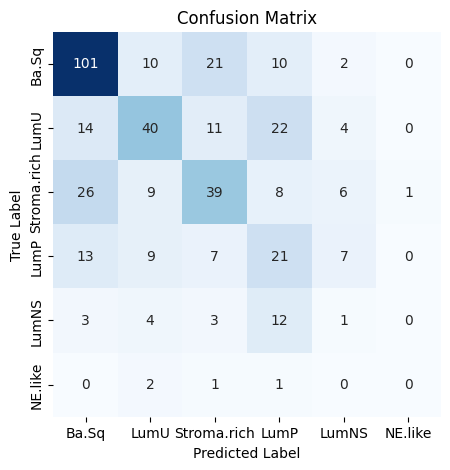

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

class_names = ['Ba.Sq', 'LumU', 'Stroma.rich', 'LumP','LumNS', 'NE.like',]
conf_matrix = confusion_matrix(
    df["target"], 
    df["prediction"],
    labels=class_names,
)
# conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

fig = plt.figure(figsize=(5, 5))
heatmap = sns.heatmap(conf_matrix, annot=True, fmt=".0f", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')


In [21]:
from sklearn.metrics import classification_report

d = classification_report(df["target"], df["prediction"],  output_dict=True, zero_division=0)
d

{'Ba.Sq': {'precision': 0.610062893081761,
  'recall': 0.6736111111111112,
  'f1-score': 0.6402640264026402,
  'support': 144.0},
 'LumNS': {'precision': 0.11764705882352941,
  'recall': 0.08695652173913043,
  'f1-score': 0.09999999999999999,
  'support': 23.0},
 'LumP': {'precision': 0.24390243902439024,
  'recall': 0.17543859649122806,
  'f1-score': 0.2040816326530612,
  'support': 57.0},
 'LumU': {'precision': 0.42592592592592593,
  'recall': 0.5054945054945055,
  'f1-score': 0.4623115577889447,
  'support': 91.0},
 'NE.like': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4.0},
 'Stroma.rich': {'precision': 0.4444444444444444,
  'recall': 0.4044943820224719,
  'f1-score': 0.4235294117647059,
  'support': 89.0},
 'accuracy': 0.4681372549019608,
 'macro avg': {'precision': 0.30699712688334185,
  'recall': 0.3076658528097412,
  'f1-score': 0.30503110476822537,
  'support': 408.0},
 'weighted avg': {'precision': 0.44797106077431326,
  'recall': 0.4681372549019608,
  'f1-

## Stats

In [9]:
import os
import pandas as pd

tiles_path = "/Users/aliceblondel/Desktop/wsi_mil/data/Embeddings/Ctranspath_PCA/tiles"
df = pd.read_csv("/Users/aliceblondel/Desktop/wsi_mil/split_test.csv")

In [48]:
import os
import numpy as np
import pandas as pd

tiles_path = "/Users/aliceblondel/Desktop/wsi_mil/data/Embeddings/Ctranspath_PCA/tiles"
df = pd.read_csv("/Users/aliceblondel/Desktop/wsi_mil/split_test.csv")

d = {'Ba.Sq':[], 'LumU':[], 'Stroma.rich':[], 'NE.like':[], 'LumP':[], 'LumNS':[],}

for file in os.listdir(tiles_path):
    zone_id = file.split(".npy")[0]
    target = df[df["zone_id"]==zone_id]["target"].iloc[0]
    if target=="NE.like":

        patient = df[df["zone_id"]==zone_id]["patient_id"].iloc[0]

        path = os.path.join(tiles_path, file)
        emb = np.load(path)
        n_tiles = emb.shape[0]

        d[target].append(n_tiles)
        d[target].append(patient)


In [41]:
for c, cards in d.items():
    print(c, ":", np.min(cards))

Ba.Sq : 72
LumU : 102
Stroma.rich : 31
NE.like : 76
LumP : 69
LumNS : 164


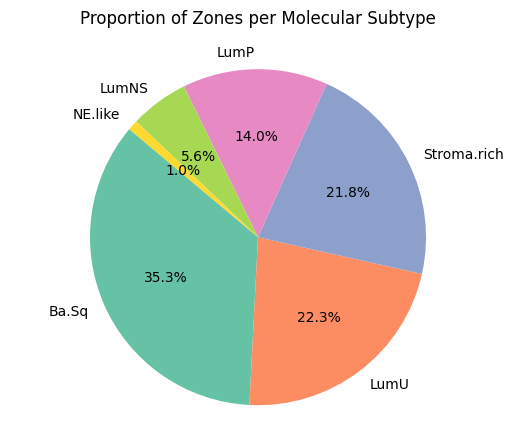

In [96]:
import matplotlib.pyplot as plt

# Data
labels = ['Ba.Sq', 'LumU', 'Stroma.rich', 'LumP', 'LumNS', 'NE.like']
# sizes = [68768, 46585, 35513, 27858, 11091, 2366]
sizes = [144, 91, 89, 57, 23, 4]

# Define neutral colors
neutral_colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f']

# Create a pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=neutral_colors)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Add a title
plt.title('Proportion of Zones per Molecular Subtype\n')

# Display the chart
plt.show()


In [34]:
t = np.array([144/408, 91/408, 89/408, 57/408, 23/408, 4/408])
t, (t**2).sum(), 1/6



(array([0.35294118, 0.22303922, 0.21813725, 0.13970588, 0.05637255,
        0.00980392]),
 0.24468954248366018,
 0.16666666666666666)